In [1]:
# import libraries 
! pip install mesa --quiet
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.visualization import TextVisualization
from mesa.batchrunner import BatchRunner
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import defaultdict
import numpy as np
from mesa import Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


# Agent (Voters, Polling Locations) 

In [2]:
def get_distance(pos_1, pos_2):
    """
    Get the distance between two points.
    Input: pos_1, pos_2: Coordinate tuples for both points.
    Returns: distance between the points
    """
    x1, y1 = pos_1
    x2, y2 = pos_2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt(dx ** 2 + dy ** 2)


class Voter(Agent):
    '''
    Voter Agents that move around the grid. Agents are endowed with
    certain random capacities at their construction, vision. All voting status 
    is 0 at the starting point. 
    vote: voting status, 1 represents vote, 0 represents not vote
    vision: the cost of going to the polling location. Some people have the 
    resources to go to the polling location that's far from their neighberhood. 
        
    '''
    def __init__(self, pos, model, moore=False, vision=0, speed = 1):
        super().__init__(pos, model)
        self.pos = pos
        self.moore = moore
        self.vote = 0 #fixed initial voting status 
        self.vision = vision
        self.speed = speed 
       

    def go_vote(self, pos):
        '''
        Goes to a polling location at a particular cell in the grid.
        '''
        this_cell = self.model.grid.get_cell_list_contents([pos])
        for agent in this_cell:
            if type(agent) is PollingLocation:
                return agent

    def is_occupied(self, pos):
        '''
        Checks if a cell in the grid is occupied by another human agent
        '''
        this_cell = self.model.grid.get_cell_list_contents([pos])
        if pos == self.pos:
            return False
        else: 
            return len(this_cell) > 1
        

    def move(self):
        '''
        Agent moves to a neighboring cell that has an unoccupied voting machine. 
        In the case of a tie, agent moves to the closest cell. 
        '''
        # Get neighborhood within vision (where cells are unoccupied)
        visible_squres = [i for i in self.model.grid.get_neighborhood(pos=self.pos,
                                                      moore=self.moore,
                                                        include_center=False,
                                                        radius=self.vision)
                     if not self.is_occupied(i)]
        
        neighbors = [i for i in self.model.grid.get_neighborhood(pos=self.pos,
                                                      moore=self.moore,
                                                        include_center=True,
                                                        radius=self.speed)
                     if not self.is_occupied(i)]

        # find closest machine 
        closest_machine = None
        closest_dist = 10000000
        for pos in visible_squres: 
            if self.go_vote(pos).amount == 1: 
                # machine = self.go_vote(pos)
                distance = get_distance(self.pos, pos) 
                if distance < closest_dist: 
                    closest_dist = distance
                    closest_machine = pos
        
        if closest_machine is None: 
            self.random.shuffle(neighbors)
            self.model.grid.move_agent(self, neighbors[0])
            return 
                    
        # find cloest neighbors to the machine 
        cloest_neighbor = None 
        cloest_neigh_dist = 10000000 
        for pos in neighbors: 
            neighbor_dist = get_distance(pos, closest_machine)
            if neighbor_dist < cloest_neigh_dist:
                cloest_neigh_dist = neighbor_dist
                cloest_neighbor = pos 

        self.model.grid.move_agent(self, cloest_neighbor)

    def voted(self):
        '''
        Cast their votes at current location. Updates agent's voting status, 
        which is 1 if they vote and also updates the voting machine, to 0, 
        which means that the current machine is occupied. 
        
        '''
        voting_patch = self.go_vote(self.pos) 
        self.vote = self.vote + voting_patch.amount
        voting_patch.amount = 0

    def step(self):
        '''
        At each step, agents move to a new square in the grid (if it has more
        voting machine than the location they're currently in). 
        They cast their votes at this location.

        If the agent's vote status becomes 1, then they already voted, and we 
        remove them from the simulation. The rest of agents here are disfrenchied. 
        
        '''
        self.move()
        self.voted()
        if self.vote > 0:
            self.model.grid._remove_agent(self.pos, self)
            self.model.schedule.remove(self)


class PollingLocation(Agent):
    '''
    The polling locations patches themselves are an agent as well, with a certain maximum
    amount of voting machines (1) available at the location.

    If other agents in the simulation occupy the machine, it will be 0. The machine
    will become 1 per time step as the already voted agents disappear from grid.
    
    '''
    def __init__(self, pos, model, max_votingmachines, speed = 0):
        super().__init__(pos, model)
        self.amount = max_votingmachines
        self.max_votingmachines = max_votingmachines
        self.speed = speed

    def step(self):
        '''
        At each time step, vm is set back to 1 per time step.
        '''
        self.amount = min([self.max_votingmachines, self.amount + 1])

# Schedule 

In [3]:
class RandomActivationByBreed(RandomActivation):
    """
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.

    This is equivalent to the NetLogo 'ask breed...' and is generally the
    default behavior for an ABM.

    Assumes that all agents have a step() method.
    """

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_breed = defaultdict(dict)

    def add(self, agent):
        """
        Add an Agent object to the schedule

        Args:
            agent: An Agent to be added to the schedule.
        """

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_breed[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        """
        Remove all instances of a given agent from the schedule.
        """

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_breed[agent_class][agent.unique_id]

    def step(self, by_breed=True):
        """
        Executes the step of each agent breed, one at a time, in random order.

        Args:
            by_breed: If True, run all agents of a single breed before running
                      the next one.
        """
        if by_breed:
            for agent_class in self.agents_by_breed:
                self.step_breed(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_breed(self, breed):
        """
        Shuffle order and run all agents of a given breed.

        Args:
            breed: Class object of the breed to run.
        """
        agent_keys = list(self.agents_by_breed[breed].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_breed[breed][agent_key].step()

    def get_breed_count(self, breed_class):
        """
        Returns the current number of agents of certain breed in the queue.
        """
        return len(self.agents_by_breed[breed_class].values())
    


# Model

In [40]:
def get_num_rich_agents(model):
    """return number of rich agents"""

    rich_agents = [a for a in model.schedule.agents if a.speed == 6]
    return len(rich_agents)


def get_num_poor_agents(model):
    """return number of poor agents"""

    poor_agents = [a for a in model.schedule.agents if a.speed == 1]
    return len(poor_agents)

def get_num_mid_agents(model):
    """return number of middle class agents"""

    middle_agents = [a for a in model.schedule.agents if a.speed == 3]
    return len(middle_agents)


def total_disenfranchised(model):
    """sum of all disenfranchised voters"""

    rich = get_num_rich_agents(model)
    poor = get_num_poor_agents(model)
    mid = get_num_mid_agents(model)
    return rich + poor + mid

def pc_disenfranchised(model):
    """percent of all disenfranchised voters"""

    tot = total_disenfranchised(model)
    initial_voters = model.initial_voters
    return tot/initial_voters

def pc_disenfranchised_poor(model):
    """percent of poor disenfranchised voters"""

    tot_poor = get_num_poor_agents(model)
    initial_voters = model.initial_voters
    ini_poor = initial_voters * 0.6
    return tot_poor / ini_poor

def pc_disenfranchised_mid(model):
    """percent of mid disenfranchised voters"""

    tot_mid = get_num_mid_agents(model)
    initial_voters = model.initial_voters
    ini_mid = initial_voters * 0.3
    return tot_mid / ini_mid

def pc_disenfranchised_rich(model):
    """percent of rich disenfranchised voters"""

    tot_rich = get_num_rich_agents(model)
    initial_voters = model.initial_voters
    ini_rich = initial_voters * 0.1
    return tot_rich / ini_rich

# there are 116 voting machines in the grid 
def num_machines_per100(model): 
    initial_voters = model.initial_voters
    return int(116 / initial_voters * 100)


class Voting(Model):
    """
    Voting Simulation
    """

    #verbose = True  # Print-monitoring

    def __init__(self, height=50, width=50, initial_voters=500, verbose=False):
        """
        Create a new Constant Growback model with the given parameters.

        Args:
            initial_voters: Number of voters to start with
        """

        # Set parameters
        self.height = height
        self.width = width
        self.initial_voters = initial_voters
        self.verbose = verbose
        
        self.schedule = RandomActivationByBreed(self)
        self.grid = MultiGrid(self.height, self.width, torus=False)

        # collect data throughout simulation on the number of disfranchised voted
        # at each time step
        self.datacollector = DataCollector(
            model_reporters={
                "PC_Rich_Disenfranchised": pc_disenfranchised_rich,
                "PC_Poor_Disenfranchised": pc_disenfranchised_poor,
                "PC_Mid_Disenfranchised": pc_disenfranchised_mid,
                "PC Disenfranchised Voters": pc_disenfranchised,
             })
        

        # When a voting machine is available, which is when one human agent 
        # finishes casting their vote, we set it back to 1. 
        # pre-defined voting machine locations can be found at pollinglocation-map.txt
        machine_distribution = np.genfromtxt("voting_cg/pollinglocation_map.txt")
        for _, x, y in self.grid.coord_iter():
            # set max vm to pre-defined amount
            max_votingmachines = machine_distribution[x, y]
            machine = PollingLocation((x, y), self, max_votingmachines)

            # place voting machines on the grid and add it to the schedule
            self.grid.place_agent(machine, (x, y))
            self.schedule.add(machine)
          
        # Create voters with vision = 10, different speeds (1,2,4)
        chosen_already = set([])
        for i in range(self.initial_voters):
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            while (x,y) in chosen_already:
                x = self.random.randrange(self.width)
                y = self.random.randrange(self.height)
        
            chosen_already.add((x,y))
            #vision = self.random.choices([10,13,16], weights=[.6, .3, .1], k=1)[0]
            vision = 10 # set a fixed vision 
            speed = self.random.choices([1,3,6], weights=[.6, .3, .1], k=1)[0]
            #speed = 10 # set a fixed speed to isolate the effect of vision as a test
            voter_agent = Voter((x, y), self, False, vision, speed)

            # place agent at a random location in the grid to start and add to
            # schedule
            self.grid.place_agent(voter_agent, (x, y))
            self.schedule.add(voter_agent)

        self.running = True
        self.datacollector.collect(self)
            
    def step(self):
        self.schedule.step()

        # collect data after each step on how many agents do not vote yet
        self.datacollector.collect(self)

        if self.verbose:
            print([self.schedule.time, self.schedule.get_breed_count(Voter)])

    def run_model(self, step_count=200):
        '''
        Run model over a set number of steps (e.g. 200) and report number of
        agents at the beginning and end of simulation (if verbose is
        uncommented at the beginning of the code)
        '''
        if self.verbose:
            print(
                "Initial number of Voters: ",
                self.schedule.get_breed_count(Voter),
            )

        for i in range(step_count):
            self.step()

        if self.verbose:
            print("")
            print(
                "Disfranchised Voters: ",
                self.schedule.get_breed_count(Voter),
            )


# Analysis 

1. We first isolated the effect of speed on voter turnout (Rich:speed=6,Mid Class:speed=3,Poor:speed=1) 

In [5]:
# run the model 100 steps
model = Voting()
while model.running and model.schedule.steps < 100:
    model.step()


In [6]:
df = model.datacollector.get_model_vars_dataframe()
df.head()

,Rich,Poor,Middle Class,Disenfranchised Voters
0,48,309,143,500
1,25,289,114,428
2,13,269,80,362
3,7,248,54,309
4,2,227,44,273


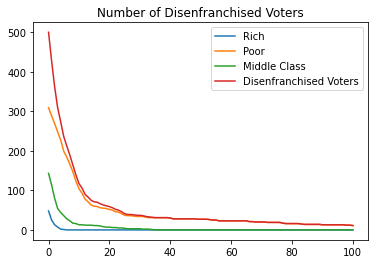

In [7]:
# plot the graph of number of disenfranchised voters agaist the steps 
df.plot(title='Number of Disenfranchised Voters');

Let's produce a graph that shows the proportion of voters being disenfranchised

In [14]:
model = Voting()
while model.running and model.schedule.steps < 20:
    model.step()

df = model.datacollector.get_model_vars_dataframe()
df.head()

,PC_Rich_Disenfranchised,PC_Poor_Disenfranchised,PC_Mid_Disenfranchised,PC Disenfranchised Voters
0,0.94,0.98,1.060000,1.000
1,0.52,0.90,0.913333,0.866
2,0.20,0.87,0.686667,0.748
3,0.12,0.82,0.493333,0.652
4,0.06,0.75,0.326667,0.554


In [15]:
df

,PC_Rich_Disenfranchised,PC_Poor_Disenfranchised,PC_Mid_Disenfranchised,PC Disenfranchised Voters
0,0.94,0.980000,1.060000,1.000
1,0.52,0.900000,0.913333,0.866
2,0.20,0.870000,0.686667,0.748
3,0.12,0.820000,0.493333,0.652
4,0.06,0.750000,0.326667,0.554
5,0.04,0.666667,0.260000,0.482
6,0.02,0.593333,0.226667,0.426
7,0.02,0.533333,0.213333,0.386
8,0.02,0.466667,0.180000,0.336
9,0.02,0.420000,0.140000,0.296


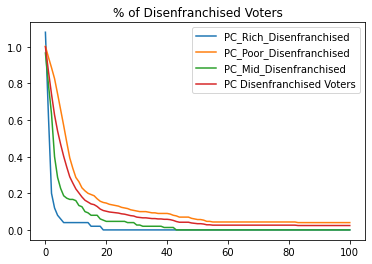

In [10]:
df.plot(title='% of Disenfranchised Voters');

Now we'd like to isolate the effect on vision on voter turnout

In [20]:
model = Voting()
while model.running and model.schedule.steps < 20:
    model.step()

df = model.datacollector.get_model_vars_dataframe()


In [21]:
df

,PC_Rich_Disenfranchised,PC_Poor_Disenfranchised,PC_Mid_Disenfranchised,PC Disenfranchised Voters
0,1.10,0.953333,1.060000,1.000
1,0.70,0.896667,0.840000,0.860
2,0.30,0.866667,0.626667,0.738
3,0.26,0.820000,0.413333,0.642
4,0.16,0.763333,0.306667,0.566
5,0.14,0.690000,0.220000,0.494
6,0.10,0.603333,0.200000,0.432
7,0.10,0.516667,0.200000,0.380
8,0.04,0.450000,0.186667,0.330
9,0.04,0.373333,0.173333,0.280


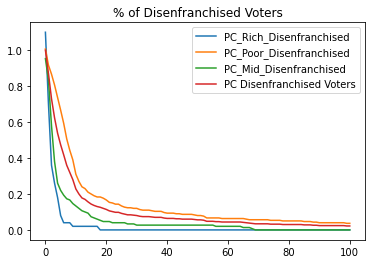

In [19]:
df.plot(title='% of Disenfranchised Voters');

Let’s run the model again when those two parameters interact ...

In [38]:
model = Voting()
while model.running and model.schedule.steps < 10:
    model.step()

df = model.datacollector.get_model_vars_dataframe()

In [39]:
df

,PC_Rich_Disenfranchised,PC_Poor_Disenfranchised,PC_Mid_Disenfranchised,PC Disenfranchised Voters
0,1.14,0.996667,0.960000,1.000
1,0.58,0.926667,0.826667,0.862
2,0.32,0.866667,0.620000,0.738
3,0.22,0.836667,0.360000,0.632
4,0.14,0.736667,0.260000,0.534
5,0.08,0.643333,0.206667,0.456
6,0.04,0.576667,0.193333,0.408
7,0.02,0.496667,0.153333,0.346
8,0.02,0.423333,0.146667,0.300
9,0.02,0.356667,0.133333,0.256


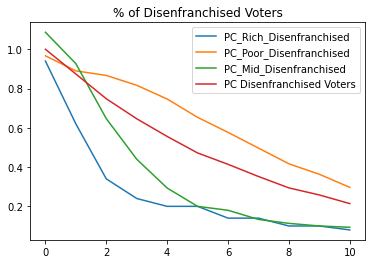

In [37]:
df.plot(title='% of Disenfranchised Voters');

Now we'd like to see the effect of having more voting machines on voter turnout

In [112]:
import numpy as np
from mesa.batchrunner import BatchRunner

fixed_params = {"height": 50, "width": 50} 
variable_parms = {"initial_voters": np.arange(300, 900, 100)}
model_reporters = {"Percent Disenfranchised Voters": pc_disenfranchised,
                   "Percent Poor Disenfranchised Voters": pc_disenfranchised_poor,
                   "Percent Mid Disenfranchised Voters": pc_disenfranchised_mid,
                   "Percent Rich Disenfranchised Voters": pc_disenfranchised_rich,
                   "Num_Machine_Per100": num_machines_per100,}


br = BatchRunner(Voting,
                 variable_parameters=variable_parms,
                 fixed_parameters=fixed_params,
                 iterations=20,
                 max_steps=15,
                 model_reporters=model_reporters)

In [113]:
br.run_all()

120it [05:02,  2.52s/it]


In [115]:
df = br.get_model_vars_dataframe()
df

,initial_voters,Run,Num_Machine_Per100,Percent Disenfranchised Voters,Percent Mid Disenfranchised Voters,Percent Poor Disenfranchised Voters,Percent Rich Disenfranchised Voters,height,width
0,300,0,38,0.146667,0.044444,0.222222,0.000000,50,50
1,300,1,38,0.136667,0.055556,0.200000,0.000000,50,50
2,300,2,38,0.160000,0.111111,0.205556,0.033333,50,50
3,300,3,38,0.110000,0.033333,0.166667,0.000000,50,50
4,300,4,38,0.123333,0.022222,0.194444,0.000000,50,50
...,...,...,...,...,...,...,...,...,...
115,800,115,14,0.172500,0.070833,0.247917,0.025000,50,50
116,800,116,14,0.171250,0.075000,0.245833,0.012500,50,50
117,800,117,14,0.157500,0.079167,0.222917,0.000000,50,50
118,800,118,14,0.151250,0.062500,0.216667,0.025000,50,50


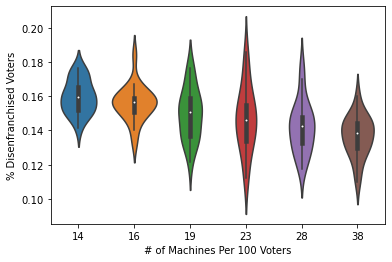

In [116]:
sns.violinplot(x='Num_Machine_Per100', y='Percent Disenfranchised Voters', data=df)
plt.xlabel('# of Machines Per 100 Voters')
plt.ylabel('% Disenfranchised Voters'); 

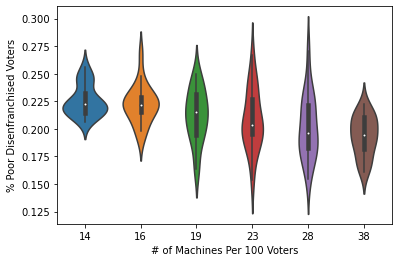

In [117]:
sns.violinplot(x='Num_Machine_Per100', y='Percent Poor Disenfranchised Voters', data=df)
plt.xlabel('# of Machines Per 100 Voters')
plt.ylabel('% Poor Disenfranchised Voters'); 

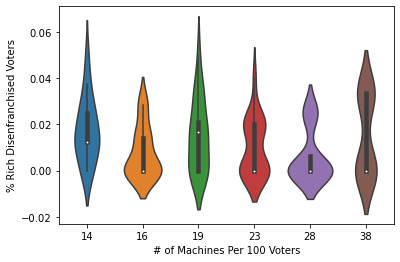

In [118]:
sns.violinplot(x='Num_Machine_Per100', y='Percent Rich Disenfranchised Voters', data=df)
plt.xlabel('# of Machines Per 100 Voters')
plt.ylabel('% Rich Disenfranchised Voters'); 

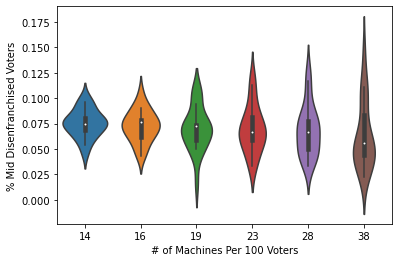

In [119]:
sns.violinplot(x='Num_Machine_Per100', y='Percent Mid Disenfranchised Voters', data=df)
plt.xlabel('# of Machines Per 100 Voters')
plt.ylabel('% Mid Disenfranchised Voters'); 

In [125]:
grouped_df = df.groupby("Num_Machine_Per100")
mean_df = grouped_df.mean()
mean_df = mean_df.reset_index()
mean_df

,Num_Machine_Per100,initial_voters,Run,Percent Disenfranchised Voters,Percent Mid Disenfranchised Voters,Percent Poor Disenfranchised Voters,Percent Rich Disenfranchised Voters,height,width
0,14,800.0,109.5,0.159812,0.075208,0.225833,0.017500,50.0,50.0
1,16,700.0,89.5,0.156000,0.072619,0.222381,0.007857,50.0,50.0
2,19,600.0,69.5,0.149833,0.070000,0.212222,0.015000,50.0,50.0
3,23,500.0,49.5,0.147000,0.069667,0.208500,0.010000,50.0,50.0
4,28,400.0,29.5,0.142250,0.068333,0.201875,0.006250,50.0,50.0
5,38,300.0,9.5,0.136667,0.063333,0.193611,0.015000,50.0,50.0


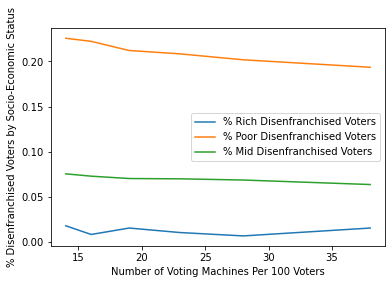

In [131]:
import matplotlib.pyplot as plt

# Plot a simple line chart
plt.plot(mean_df['Num_Machine_Per100'], mean_df['Percent Rich Disenfranchised Voters'],  label='% Rich Disenfranchised Voters')

plt.plot(mean_df['Num_Machine_Per100'], mean_df['Percent Poor Disenfranchised Voters'],  label='% Poor Disenfranchised Voters')

plt.plot(mean_df['Num_Machine_Per100'], mean_df['Percent Mid Disenfranchised Voters'], label='% Mid Disenfranchised Voters')

plt.legend()
plt.xlabel('Number of Voting Machines Per 100 Voters')
plt.ylabel('% Disenfranchised Voters by Socio-Economic Status')
plt.show()